# はじめに
kaggleのタイタニックのスコアはベースラインの0.77990だった。1.0を叩き出す怪物がいて、すごい凹んだけどどうやらあの人たちはズルをしているらしい。神々の人たちも0.85くらいみたい。ネットに0.81の記事があったので、それと自分の成果を比較してタイタニックからは脱出する。

# 1. データ整理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
#train data import
data = pd.read_csv('train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survivedがターゲットのcolumn1は生きていて、0は死亡
- survival        Survival target columns  (0 = No; 1 = Yes)
- pclass          Passenger Class  (1 = 1st; 2 = 2nd; 3 = 3rd) 1が金持ち
- name            Name
- sex             Sex #名義特徴量
- age             Age
- sibsp           Number of Siblings/Spouses Aboard
- parch           Number of Parents/Children Aboard
- ticket          Ticket Number
- fare            Passenger Fare
- cabin           Cabin
- embarked        Port of Embarkation 乗り込んだ港　#名義特徴量

In [4]:
#記述統計量
data.describe()

/home/kyohei/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age columnで177個の値がmissing value。とりあえず、中央値で埋める

In [5]:
data['Age'].fillna(data['Age'].median(),inplace=True)

In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


グラフを作る。性別毎の生死。

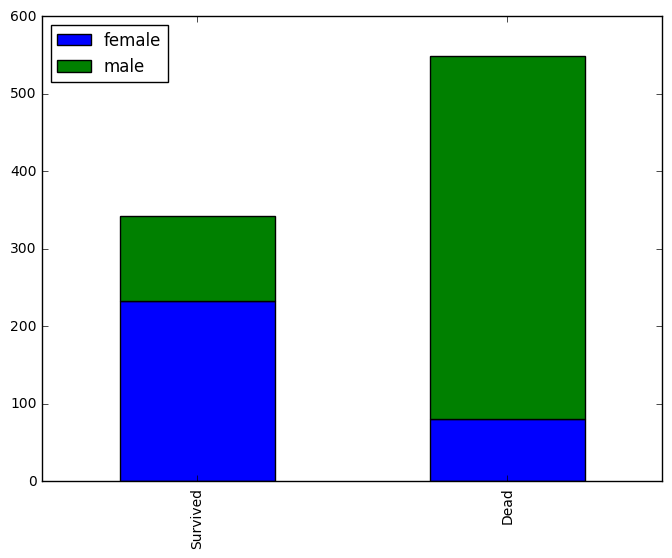

In [7]:
survived_sex = data[data['Survived']==1]['Sex'].value_counts()
dead_sex = data[data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True,figsize=(8,6))

Sex clumnは良い特徴量。女性の方が生存率が高い。次は、年齢（Age）別の生死

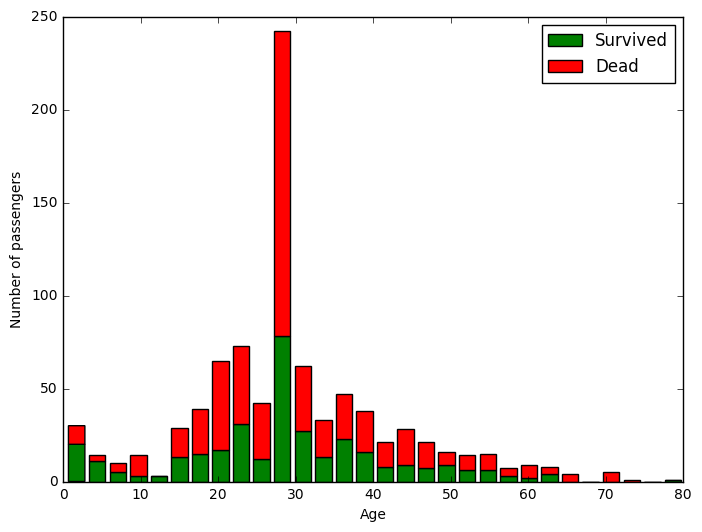

In [8]:
figure = plt.figure(figsize=(8,6))
plt.hist([data[data['Survived']==1]['Age'],data[data['Survived']==0]['Age']],stacked=True,
         color=['g','r'],bins=30,label=['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

- 10歳以下の子が生存しやすい。多分、助けの手が差し伸ばされやすい。
- 50より上の世代も助け出されやすかった模様。

年代と性別の結果から、お年寄り、女、子供を優先して助けるという救命活動が推測できる。

次にチケットと生死の相関を見る

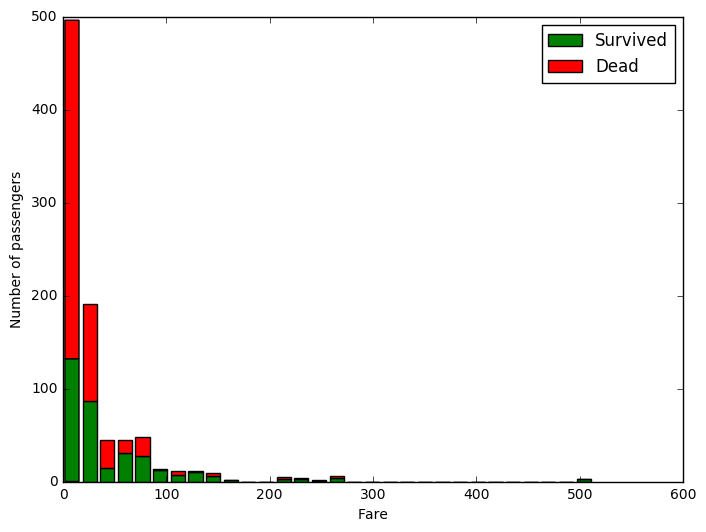

In [9]:
figure = plt.figure(figsize=(8,6))
plt.hist([data[data['Survived']==1]['Fare'],data[data['Survived']==0]['Fare']],stacked=True,color=('g','r'),
        bins=30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

安いチケットの乗客は死にやすい。高いチケットの人は生存率が高いので、社会的に高い地位の人が優先して助けられたようだ。

次に、年齢と料金をの散布図を見る

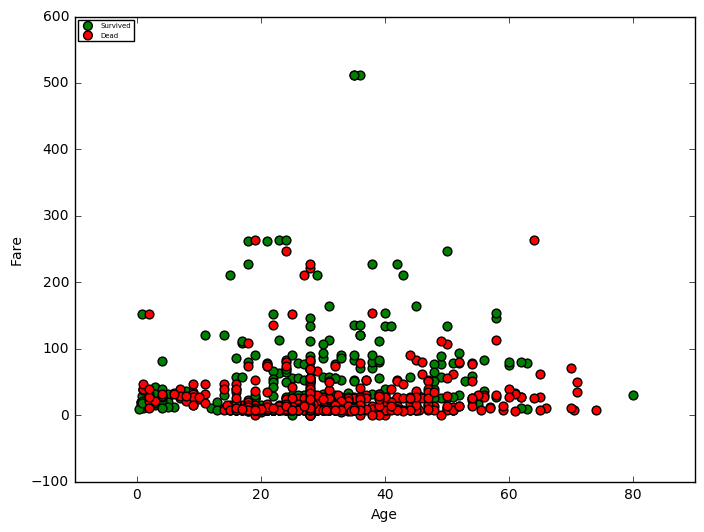

In [10]:
plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.scatter(data[data['Survived']==1]['Age'],data[data['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(data[data['Survived']==0]['Age'],data[data['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('Survived','Dead'),scatterpoints=1,loc='upper left',fontsize=5)

15〜50の間の乗客でかつ、乗車料金が低い階層でクラスタが見られる。この人たちはクラスが低いのを確かめる。

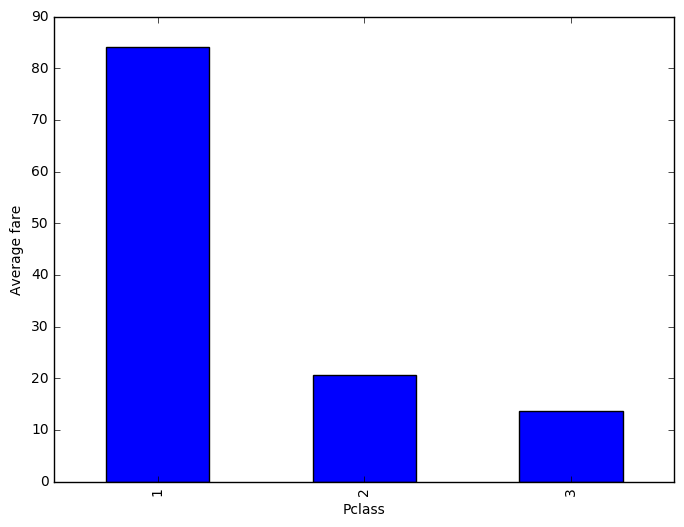

In [11]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(8,6),ax=ax)

次に港ごとの生死を確認する

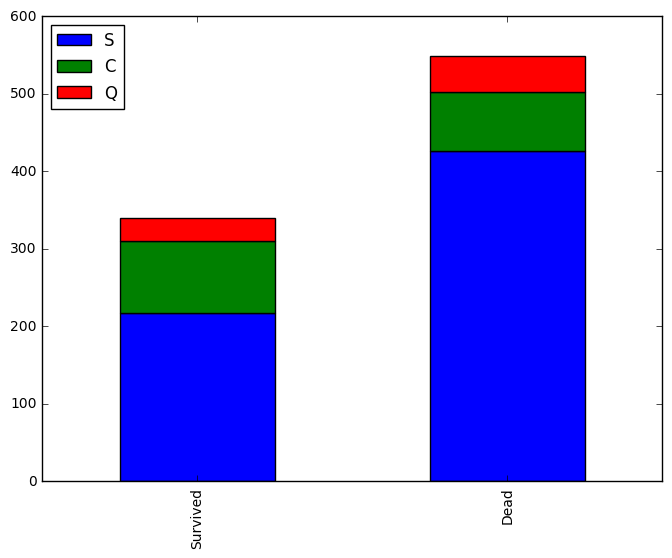

In [12]:
survived_embark = data[data['Survived']==1]['Embarked'].value_counts()
dead_embark = data[data['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived_embark,dead_embark])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked='True',figsize=(8,6))

際立った相関は見られない。

# Feature engineering
- 名前とチケットの情報を処理して特徴量を新たに作成する。

In [13]:
def status(feature):
    print 'Processing',feature,': ok'

まずは、テストデータと訓練データを合体させることから始める。

In [14]:
def get_combined_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    #訓練データから、Survived　columnを除く
    targets = train.Survived
    train.drop('Survived',1,inplace=True)
    
    #訓練とテストデータをマージする
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)
    
    return combined

In [15]:
combined = get_combined_data()

In [16]:
combined.shape

(1309, 11)

乗客の肩書を抽出する

In [17]:
import re
def get_title(name):
    #regular expressionを使って肩書を探す。肩書は必ず大文字と小文字とピリオドで構成される。
    title_search = re.search(' ([A-Za-z]+)\.',name) #該当箇所を返す
    if title_search:
        #ピリオドを除いた部分だけ返す
        return title_search.group(1)
    return ''

titles = combined['Name'].apply(get_title)

title_mapping = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

titles = titles.map(title_mapping)
combined['Title'] = titles

これまではmrsとかmr以外は、例外という風に処理していたけどofficerとかroyaltyとか、今までの分析結果を踏まえると明らかに生死に関係する。

In [18]:
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Ageの再処理を行う。さっきは中央値でやったけどこれは雑すぎる。性別、クラス、肩書毎の中央値を使う。

俺は、よくわからんから、ランダムフォレスト回帰にぶち込んでいた。決定係数は0.4くらいであまり良くなかったけど、中央値使うよりはマシだけど回帰の結果は平均値付近に集まっていた。お年寄りと子供を反映出来ていなかった。というか、子供をどうやって見極めるんだよと思ったら、実はmasterという肩書は子供用だったみたい。。。英語しらねーよ。とりあえず機械学習のツールに頼る前に、簡単な方法も検討してみるべきだね。

In [19]:
grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()

PassengerId   Age  SibSp  Parch      Fare
Sex    Pclass Title                                             
female 1      Miss           529.5  30.0    0.0    0.0   99.9625
              Mrs            853.5  45.0    1.0    0.0   78.1125
              Officer        797.0  49.0    0.0    0.0   25.9292
              Royalty        931.5  43.5    0.5    0.0   74.2500
       2      Miss           606.5  20.0    0.0    0.0   20.2500
              Mrs            533.0  30.0    1.0    0.0   26.0000
       3      Miss           603.5  18.0    0.0    0.0    8.0500
              Mrs            668.5  31.0    1.0    1.0   15.5000
male   1      Master         803.0   6.0    1.0    2.0  134.5000
              Mr             634.0  41.5    0.0    0.0   47.1000
              Officer        678.0  52.0    0.0    0.0   37.5500
              Royalty        600.0  40.0    0.0    0.0   27.7208
       2      Master         550.0   2.0    1.0    1.0   26.0000
              Mr             723.5  30.0    0.0    0.0   13.0000
              Officer        513.0  41.5    0.0    0.0   13.0000
       3      Master         789.0   6.0    3.0    1.0   22.3583
              Mr             640.5  26.0    0.0    0.0    7.8958

In [20]:
def process_age():
    
    global combined
    
    def fillAge(row):
        if row['Sex']=='female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return 30
            elif row['Title'] == 'Mrs':
                return 45
            elif row['Title'] == 'Officer':
                return 49
            elif row['Title'] == 'Royalty':
                return 39

        elif row['Sex']=='female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return 20
            elif row['Title'] == 'Mrs':
                return 30

        elif row['Sex']=='female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return 18
            elif row['Title'] == 'Mrs':
                return 31

        elif row['Sex']=='male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 41.5
            elif row['Title'] == 'Officer':
                return 52
            elif row['Title'] == 'Royalty':
                return 40

        elif row['Sex']=='male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return 2
            elif row['Title'] == 'Mr':
                return 30
            elif row['Title'] == 'Officer':
                return 41.5

        elif row['Sex']=='male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 26
    
    combined.Age = combined.apply(lambda r: fillAge(r) if np.isnan(r['Age']) else r['Age'],axis=1)

In [21]:
process_age()

In [22]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1308 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


titleのカラム作ったので名前のカラムを消す

In [23]:
combined.drop('Name',axis=1,inplace=True)
#encoding dummy variable
titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
combined = pd.concat([combined,titles_dummies],axis=1)
#remove the title column
combined.drop('Title',axis=1,inplace=True)

In [24]:
combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,0.0,0.0,1.0,0.0,0.0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,0.0,1.0,0.0,0.0
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0


Fare columnの穴埋め

In [25]:
combined.Fare.fillna(combined['Fare'].mean(),inplace=True)

Embarkedの穴埋め

In [26]:
#最頻値がSなので、それを挿入する。
combined.Embarked.fillna('S',inplace=True)

#dummy encoding
embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
combined = pd.concat([combined,embarked_dummies],axis=1)
combined.drop('Embarked',axis=1,inplace=True)

cabinは空欄が多い。空欄のものにはUnknownのUを代入する。

In [27]:
#replacing missing cabins with U
combined.Cabin.fillna('U',inplace=True)

#mapping each Cabin value eith the cabin letter
combined['Cabin'] = combined['Cabin'].map(lambda c:c[0])

#dummy encoding
cabin_dummies = pd.get_dummies(combined['Cabin'],prefix='Cabin')

combined = pd.concat([combined,cabin_dummies],axis=1)

combined.drop('Cabin',axis=1,inplace=True)

In [28]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
PassengerId      1309 non-null int64
Pclass           1309 non-null int64
Sex              1309 non-null object
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Ticket           1309 non-null object
Fare             1309 non-null float64
Title_Master     1309 non-null float64
Title_Miss       1309 non-null float64
Title_Mr         1309 non-null float64
Title_Mrs        1309 non-null float64
Title_Officer    1309 non-null float64
Title_Royalty    1309 non-null float64
Embarked_C       1309 non-null float64
Embarked_Q       1309 non-null float64
Embarked_S       1309 non-null float64
Cabin_A          1309 non-null float64
Cabin_B          1309 non-null float64
Cabin_C          1309 non-null float64
Cabin_D          1309 non-null float64
Cabin_E          1309 non-null float64
Cabin_F          1309 non-null float64
Cabin_

SEXの処理

In [29]:
combined['Sex'] = combined['Sex'].map({'male':1,'female':0})

Pclassの処理

In [30]:
#encoding into 3 categories
pclass_dummies = pd.get_dummies(combined['Pclass'],prefix='Pclass')

combined = pd.concat([combined,pclass_dummies],axis=1)

combined.drop('Pclass',axis=1,inplace=True)

ticketの処理。ticket番号の前にふられている文字列を取得する。文字列がないチケットはXXXを代入

In [31]:
def cleanticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(),ticket)
    ticket = filter(lambda t: not t.isdigit(),ticket)
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'
    
#Extracting dummy variables from tickets

combined['Ticket'] = combined['Ticket'].map(cleanticket)
tickets_dummies = pd.get_dummies(combined['Ticket'],prefix='Ticket')
combined = pd.concat([combined,tickets_dummies],axis=1)
combined.drop('Ticket',inplace=True,axis=1)

家族の処理。新しく特徴量を作成する。大きな家族の人のほうがグループを作って行動するので、より救出されやすいであろうという仮定

仮定なしに特徴量を作成しても意味ないよね。反省

In [32]:
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5<=s else 0)

In [33]:
combined.shape

(1309, 68)

特徴量は合計68個

# モデリング
- ランダムフォレストを使う

In [34]:
#import libraries
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

5-fold cross validationをつかってモデルを評価する。

In [35]:
def compute_score(clf,X,y,scoring='accuracy'):
    xval = cross_val_score(clf,X,y,cv=5,scoring=scoring)
    return np.mean(xval)

In [36]:
train0 = pd.read_csv('train.csv')

targets = train0.Survived
train = combined.ix[0:890]
test = combined.ix[891:]

68個の特徴量は大きすぎる。本質を掴んでいる特徴量に個数を減らす。

ランダムフォレスト使うのに何故Lasso回帰で特徴量の重要度を選択する??

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train,targets)

In [38]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_

In [39]:
features.sort(['importance'],ascending=False)

/home/kyohei/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,feature,importance
0,PassengerId,0.128770
8,Title_Mr,0.121501
2,Age,0.119602
5,Fare,0.113121
1,Sex,0.106017
26,Pclass_3,0.037242
7,Title_Miss,0.035989
9,Title_Mrs,0.032536
23,Cabin_U,0.025916
24,Pclass_1,0.024169


重要なのはTitle_Mr,Age,FareとSexである。Passenger_Idでも重要である。

In [40]:
model = SelectFromModel(clf,prefit=True)
train_new = model.transform(train)
train_new.shape

(891, 14)

In [41]:
test_new = model.transform(test)
test_new.shape

(418, 14)

ハイパーパラメータのチューニング

In [42]:
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.832772166105
Best parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 4}


In [43]:
output = grid_search.predict(test_new).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

分類精度上がったけど、0.8も行かねーぞ・・・（笑）誤差やん